In [1]:
import glob
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import classification_report, accuracy_score
from mpl_toolkits.mplot3d import Axes3D

### 设置训练集和测试集数据

In [2]:
# 1 2 3
target = 1

if target==1:
    data_name = '0618'
elif target==2:
    data_name = '0854'
elif target==3:
    data_name = '1066'

# 设置训练集数据
# 获取指定的CSV文件
csv_files = glob.glob(f'./RGB_data/data_{data_name}.csv')

# 设置测试集数据
new_image_path = f'./input_data/{data_name}.png'

# TRAIN

In [3]:
# 初始化一个空的DataFrame来存储合并后的数据
data = pd.DataFrame()

# 遍历所有CSV文件并将它们合并
for file in csv_files:
    df = pd.read_csv(file)
    data = pd.concat([data, df], ignore_index=True)

# 现在all_data包含了所有CSV文件的数据
print(data.shape)

(1000, 4)


In [4]:
# 读入特征和标签
features = data.drop('Label', axis=1) # 按列操作取名为’Label以外的列
labels = data['Label']
features.shape,labels.shape,type(features),type(labels)

((1000, 3), (1000,), pandas.core.frame.DataFrame, pandas.core.series.Series)

In [5]:
# 归一化
scaler = StandardScaler()

print(features.shape)
print(type(features))

features = scaler.fit_transform(features)
features = pd.DataFrame(features)

print(features.shape)
print(type(features))

features.shape,labels.shape,
type(features),type(labels)

(1000, 3)
<class 'pandas.core.frame.DataFrame'>
(1000, 3)
<class 'pandas.core.frame.DataFrame'>


(pandas.core.frame.DataFrame, pandas.core.series.Series)

In [6]:
# 划分数据集
X_train, X_test, y_train, y_test = train_test_split(features, labels,
                                     test_size=0.25, random_state=42)

In [ ]:
#网格搜索
svc_grid = svm.SVC()
param_grid = {
    'C' : [100, 10, 1, 0.1, 0.01, 0.001, 0.0001],
    #'gamma' : [0.001, 0.01, 0.1, 1, 10, 100],
    'kernel' : ['linear']
}
#estimator是上面创建的SVC实例->svc
grid_search = GridSearchCV(estimator=svc_grid, param_grid=param_grid,
                           cv=10, scoring='accuracy', verbose=1)
#模型训练
grid_search.fit(X_train, y_train)

# 输出最佳参数和最佳分数
print("Best parameters:", grid_search.best_params_)
print("Best cross-validation score:", grid_search.best_score_)

#使用最佳参数和训练集数据训练最终模型
clf = grid_search.best_estimator_
y_pred = clf.predict(X_test)

#线性SVM 对偶空间

#创建svm分类器
clf = svm.SVC(kernel='rbf', C=0.001, gamma='auto')

#训练模型
clf.fit(X_train, y_train)

#预测测试集(实际上是验证集)
y_pred = clf.predict(X_test)

In [8]:
#输出训练结果
# 数据量
positive_count = data[data['Label'] == 1]['Label'].count()
negative_count = data[data['Label'] == 0]['Label'].count()

print(f'共{data.shape[0]}个数据, {positive_count}个正样本，{negative_count}个负样本\n')

# 计算并打印准确率
accuracy = accuracy_score(y_test, y_pred)
print(f'Model accuracy: {accuracy:.2f}\n')

# 计算并打印分类报告
report = classification_report(y_test, y_pred)
print('Classification Report:\n', report)

共1000个数据, 451个正样本，549个负样本

Model accuracy: 0.98

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98       131
           1       0.99      0.97      0.98       119

    accuracy                           0.98       250
   macro avg       0.98      0.98      0.98       250
weighted avg       0.98      0.98      0.98       250



In [9]:
def plot_svm_decision_boundaries(clf, X_train, y_train):
    # 创建一个图形窗口，大小为20x10英寸
    fig = plt.figure(figsize=(20, 12))

    # 创建四个子图，排列为2行2列
    # axs是一个2x2的数组，每个元素代表一个子图对象
    axs = fig.subplots(2, 2)

    # 将子图数组展平，方便索引
    axs = axs.flatten()

    # BGR (3D) 图
    # 创建3D子图，位置在左上角（221表示2行2列中的第1个）
    ax1 = fig.add_subplot(221, projection='3d')
    # 绘制BGR数据点
    ax1.scatter(X_train[0], X_train[1], X_train[2], c=y_train, cmap=plt.cm.Paired)
    # 设置坐标轴标签
    ax1.set_xlabel('B')
    ax1.set_ylabel('G')
    ax1.set_zlabel('R')
    # 设置子图标题
    ax1.set_title('BGR Channels')

    # 获取支持向量
    support_vectors = clf.support_vectors_
    # 在3D图中绘制支持向量
    ax1.scatter(support_vectors[:, 0], support_vectors[:, 1], support_vectors[:, 2], s=100,
                 linewidth=1, facecolors='none', edgecolors='k')

    # 计算并绘制决策边界
    w = clf.coef_[0]
    b = clf.intercept_[0]
    xx = np.linspace(X_train[0].min() - 1, X_train[0].max() + 1, 10)
    yy = np.linspace(X_train[1].min() - 1, X_train[1].max() + 1, 10)
    X1, X2 = np.meshgrid(xx, yy)
    Z = -w[0] / w[2] * X1 - w[1] / w[2] * X2 - b / w[2]
    ax1.plot_surface(X1, X2, Z, alpha=0.5, rstride=1, cstride=1, color='k', linewidth=0)

    # RG 图 21
    ax2 = axs[1]
    ax2.scatter(X_train[2], X_train[1], c=y_train, cmap=plt.cm.Paired)
    ax2.set_xlabel('R')
    ax2.set_ylabel('G')
    ax2.set_title('RG Channels')

    # 在RG图中绘制支持向量
    ax1.scatter(support_vectors[:, 2], support_vectors[:, 1], s=100,
                 linewidth=1, facecolors='none', edgecolors='k')

    # 绘制RG的决策边界
    xx = np.linspace(X_train[2].min() - 1, X_train[2].max() + 1, 500)
    yy = np.linspace(X_train[1].min() - 1, X_train[1].max() + 1, 500)
    X1, X2 = np.meshgrid(xx, yy)
    Z = -w[2] / w[1] * X1 - b / w[1]
    ax2.contour(X1, X2, Z, colors='k', levels=[0], linestyles=['-'])

    # RB 图 20
    ax3 = axs[2]
    ax3.scatter(X_train[2], X_train[0], c=y_train, cmap=plt.cm.Paired)
    ax3.set_xlabel('R')
    ax3.set_ylabel('B')
    ax3.set_title('RB Channels')

    # 在RB图中绘制支持向量
    ax1.scatter(support_vectors[:, 2], support_vectors[:, 0], s=100,
                 linewidth=1, facecolors='none', edgecolors='k')

    # 绘制RB的决策边界
    xx = np.linspace(X_train[2].min() - 1, X_train[2].max() + 1, 500)
    yy = np.linspace(X_train[0].min() - 1, X_train[0].max() + 1, 500)
    X1, X2 = np.meshgrid(xx, yy)
    Z = -w[2] / w[0] * X1 - b / w[0]
    ax3.contour(X1, X2, Z, colors='k', levels=[0], linestyles=['-'])

    # BG 图 01
    ax4 = axs[3]
    ax4.scatter(X_train[0], X_train[1], c=y_train, cmap=plt.cm.Paired)
    ax4.set_xlabel('B')
    ax4.set_ylabel('G')
    ax4.set_title('BG Channels')

    # 在BG图中绘制支持向量
    ax1.scatter(support_vectors[:, 0], support_vectors[:, 1], s=100,
                 linewidth=1, facecolors='none', edgecolors='k')    

    # 绘制BG的决策边界
    xx = np.linspace(X_train[0].min() - 1, X_train[0].max() + 1, 500)
    yy = np.linspace(X_train[1].min() - 1, X_train[1].max() + 1, 500)
    X1, X2 = np.meshgrid(xx, yy)
    Z = -w[0] / w[1] * X1 - b / w[1]
    ax4.contour(X1, X2, Z, colors='k', levels=[0], linestyles=['-'])

    # 自动调整子图布局，避免重叠
    plt.tight_layout()
    # 显示图形
    plt.show()

##### 绘制数据点图像、支持向量和决策平面

#绘制linear核训练下的图像
plot_svm_decision_boundaries(clf, X_train, y_train)

In [10]:
from joblib import dump, load

# 保存模型
dump(clf, './model/svm_model.joblib')

# 加载模型
clf_loaded = load('./model/svm_model.joblib')

# TEST

In [11]:
import cv2
import os
from joblib import load

In [12]:
def load_model(model_path):
    """加载训练好的SVM模型"""
    return load(model_path)

In [13]:
def preprocess_image(image):
    h, w, _ = image.shape
    
    blue_channel = image[:, :, 0].reshape(-1)
    green_channel = image[:, :, 1].reshape(-1)
    red_channel = image[:, :, 2].reshape(-1)

    img_array = np.stack((blue_channel, green_channel, red_channel), axis=1)

    print(img_array.shape)
    
    return img_array

In [14]:
# 假设你已经有了一个训练好的模型 clf 和一个 StandardScaler 对象 scaler
model_path = './model/svm_model.joblib'
clf = load_model(model_path)

# 加载新的图片
new_image = cv2.imread(new_image_path)
new_image.shape, type(new_image)

((250, 500, 3), numpy.ndarray)

In [15]:
# 将图片数据转换为模型可以处理的格式
# 这里你需要根据你的训练数据来决定如何处理图片数据
# 例如，如果你的训练数据是图片的某些特征，你需要提取这些特征
# 这里只是一个示例，你需要根据实际情况调整
new_features = preprocess_image(new_image)  # 你需要定义这个函数
new_features

(125000, 3)


array([[ 3,  3,  3],
       [11, 11, 11],
       [10, 10, 10],
       ...,
       [87, 83, 87],
       [87, 84, 88],
       [19, 17, 20]], dtype=uint8)

In [16]:
# 使用相同的StandardScaler进行标准化
new_features = scaler.transform(new_features)
new_features.shape, type(new_features)

/home/crisi/miniconda3/envs/PR/lib/python3.9/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


((125000, 3), numpy.ndarray)

In [17]:
# 使用模型进行预测
prediction = clf.predict(new_features)

In [18]:
# 假设你已经得到了BGR三通道的归一化数组 new_features
# new_features 的形状应该是 (n_samples, 3)，其中 n_samples 是像素的数量

# 假设 clf 是你已经训练好的模型
# 例如：clf = SVC(C=1.0, kernel='linear')

# 使用模型进行预测
# 注意：这里假设 new_features 已经是归一化后的数组，并且形状正确
predictions = clf.predict(new_features)

# 将预测结果应用到图片上
# 假设 original_image 是原始图片的NumPy数组
original_image = new_image
height, width, _ = original_image.shape
predicted_image = np.zeros_like(original_image)

for i in range(height):
    for j in range(width):
        # 获取当前像素的索引
        pixel_index = i * width + j
        
        # 根据预测结果设置像素的颜色
        if predictions[pixel_index] == 1:
            predicted_image[i, j] = (255, 255, 255)  # 白色
        else:
            predicted_image[i, j] = (0, 0, 0)  # 黑色

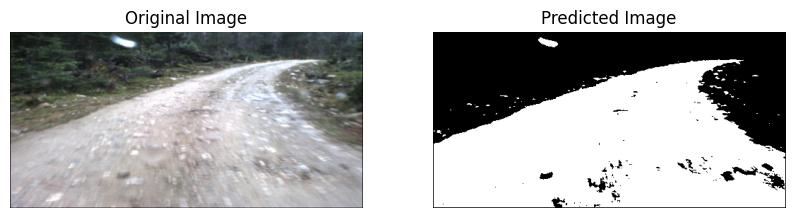

Predicted image saved to ./result_img/pred_0618_rbf.jpg


In [19]:
# 显示原始图片
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(cv2.cvtColor(original_image, cv2.COLOR_BGR2RGB))
plt.title('Original Image')
plt.axis('off')

# 显示预测后的图片
plt.subplot(1, 2, 2)
plt.imshow(cv2.cvtColor(predicted_image, cv2.COLOR_BGR2RGB))
plt.title('Predicted Image')
plt.axis('off')

# 显示图像
plt.show()
    
# 保存预测后的图片
new_image_name = os.path.splitext(os.path.basename(new_image_path))[0]
save_path = f'./result_img/pred_{new_image_name}_origin.jpg'
cv2.imwrite(save_path, predicted_image)
print(f'Predicted image saved to {save_path}')